In [8]:
from skyfield import api
import ephem
import numpy as np
from scipy.spatial.transform import Rotation as R
import toast.qarray as qa
import healpy as hp
import matplotlib.pyplot as plt

In [9]:
def get_error_angles(ra1, dec1, ra2, dec2):
    
    return np.arccos(np.dot(hp.ang2vec(np.pi/2-dec1, ra1), hp.ang2vec(np.pi/2-dec2, ra2)))

In [24]:
input_az = 2.5
input_el = -1
z = np.array([0,0,1])

In [25]:
ephem.date('2020/6/19 12:00:00')

44000.0

In [26]:
noeffects_observer = ephem.Observer()
noeffects_observer.pressure=0
noeffects_observer.lon='-67:47:10.6' 
noeffects_observer.lat='-22:57:28.5' 
noeffects_observer.elevation=5156.0
noeffects_observer.date=44000
noeffects_observer.epoch = -9786
noeffects_observer

<ephem.Observer date='2020/6/19 12:00:00' epoch='1873/3/16 12:00:00' lon='-67:47:10.6' lat='-22:57:28.5' elevation=5156.0m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>

In [27]:
effects_observer = ephem.Observer()
effects_observer.pressure=0
effects_observer.lon='-67:47:10.6' 
effects_observer.lat='-22:57:28.5' 
effects_observer.elevation=5156.0
effects_observer.date=44000
effects_observer.epoch = ephem.J2000
effects_observer

<ephem.Observer date='2020/6/19 12:00:00' epoch='2000/1/1 12:00:00' lon='-67:47:10.6' lat='-22:57:28.5' elevation=5156.0m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>

(17.205900760107358, 0.2709146583112825)

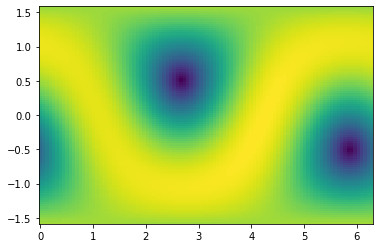

In [28]:
#sweep over azel
az_sweep = np.linspace(0, 2*np.pi, 100)
el_sweep = np.linspace(-np.pi/2, np.pi/2, 100)

errors = np.zeros((len(az_sweep), len(el_sweep)))
for i, az in enumerate(az_sweep):
    for j, el in enumerate(el_sweep):
        ra, dec = effects_observer.radec_of(az, el)
        ra1, dec1 = noeffects_observer.radec_of(az, el)
        errors[j][i] = get_error_angles(ra, dec, ra1, dec1)
        
X, Y = np.meshgrid(az_sweep, el_sweep)
plt.pcolormesh(X, Y, errors)
np.nanmax(errors) * 180/np.pi * 60 , np.nanmin(errors) * 180/np.pi * 60 

In [29]:
target_ra, target_dec = noeffects_observer.radec_of(input_az, input_el)
print(target_ra, target_dec)

12:05:52.64 -4:02:03.5


In [30]:
target_ra, target_dec = effects_observer.radec_of(input_az, input_el)
print(target_ra, target_dec)

12:04:50.65 -3:55:18.7


In [105]:
azel_quat = qa.from_angles(
    np.pi/2 - input_el,
    -1.*input_az,
    0,
)
r_azel_quat = R.from_quat(azel_quat)

xra, xdec = effects_observer.radec_of(0, 0)
yra, ydec = effects_observer.radec_of(-np.pi/2, 0)
zra, zdec = effects_observer.radec_of(0, np.pi/2)

xvec, yvec, zvec = hp.ang2vec(np.pi/2 - np.array([xdec, ydec, zdec]),
                           np.array([xra, yra, zra]))

xvec /= np.sqrt(np.dot(xvec, xvec))
yvec -= np.dot(xvec, yvec) * xvec
yvec /= np.sqrt(np.dot(yvec, yvec))
zvec -= np.dot(xvec, zvec) * xvec + np.dot(yvec, zvec) * yvec
zvec /= np.sqrt(np.dot(zvec, zvec))

# Solve for the quaternions from the transformed axes.
X = (xvec[1] + yvec[0]) / 4
Y = (xvec[2] + zvec[0]) / 4
Z = (yvec[2] + zvec[1]) / 4

d = np.sqrt(np.abs(Y * Z / X)) # Choose positive root
c = d * X / Y
b = X / c
a = (xvec[1]/2 - b*c) / d

# qarray has the scalar part as the last index
conversion_quat = qa.norm(np.array([b, c, d, a]))
# boresight_quat = qa.mult(conversion_quat, azel_quat)
# theta, phi, p = qa.to_angles(boresight_quat)

r_conversion_quat = R.from_quat(conversion_quat)
r_boresight = r_conversion_quat * r_azel_quat

In [106]:
r_boresight.apply(z), hp.ang2vec(np.pi/2-target_dec, target_ra)

(array([ 0.45640047,  0.51207246, -0.72765404]),
 array([ 0.45540545,  0.51417611, -0.72679351]))

In [107]:
np.arccos(np.dot(r_boresight.apply(z), hp.ang2vec(np.pi/2-target_dec, target_ra))) * 180/np.pi * 60 *60

511.76660103386973

In [42]:
# theta, phi, p

In [43]:
obj = ephem.FixedBody()
obj._ra = target_ra
obj._dec = target_dec
obj._epoch = -9786

obj.compute(ephem_observer)

In [44]:
(obj.parallactic_angle() + p) 

-1.3143454025003036

In [78]:
effects_observer.radec_of(2.5, 1)

(0.8431006434732393, -0.8149841438997636)

In [79]:
noeffects_observer.radec_of(2.5, 1)

(0.8459385454733988, -0.8136419868337379)

In [83]:
effects_observer

<ephem.Observer date='2020/6/19 12:00:00' epoch='2000/1/1 12:00:00' lon='-67:47:10.6' lat='-22:57:28.5' elevation=5156.0m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>

In [84]:
noeffects_observer

<ephem.Observer date='2020/6/19 12:00:00' epoch='1873/3/16 12:00:00' lon='-67:47:10.6' lat='-22:57:28.5' elevation=5156.0m horizon=0:00:00.0 temp=15.0C pressure=0.0mBar>

In [21]:
ts = api.load.timescale()
t = ts.tt_jd(2415020.0 + 44000)
t.tt_strftime()

'2020-06-19 12:00:00 TT'

In [22]:
observer = api.wgs84.latlon(latitude_degrees = -22.957906, longitude_degrees=-67.78628, elevation_m = 5156)
observer

# observer.refract(altitude_degrees=0, temperature_C=0, pressure_mbar=0)

<GeographicPosition WGS84 latitude -22.9579 N longitude -67.7863 E elevation 5156.0 m>

In [69]:
from skyfield import units

In [114]:
pos = observer.at(t).from_altaz(alt_degrees = input_el*180/np.pi, az_degrees = input_az*180/np.pi)
pos.speed = units.Velocity(au_per_d=100)
pos.distance = units.Distance(au= 1e13)
target_ra, target_dec, _ = pos.radec(epoch=None)
target_ra, target_dec

(<Angle 06h 09m 22.82s>, <Angle -56deg 32' 48.7">)

In [115]:
pos = observer.at(t).from_altaz(alt_degrees = input_el*180/np.pi, az_degrees = input_az*180/np.pi)
pos.speed = units.Velocity(au_per_d=0)
pos.distance = units.Distance(au= 0.1)
target_ra, target_dec, _ = pos.radec(epoch=None)
target_ra, target_dec

(<Angle 06h 09m 22.82s>, <Angle -56deg 32' 48.7">)

In [39]:
azel_quat = qa.from_angles(
    np.pi/2 - input_el,
    -1.*input_az,
    0,
)
r_azel_quat = R.from_quat(azel_quat)

xra, xdec, _ = observer.at(t).from_altaz(alt_degrees = 0, az_degrees = 0).radec(epoch=ts.J2000)
yra, ydec, _ = observer.at(t).from_altaz(alt_degrees = 0, az_degrees = -90).radec(epoch=ts.J2000)
zra, zdec, _ = observer.at(t).from_altaz(alt_degrees = 90, az_degrees = 0).radec(epoch=ts.J2000)

xvec, yvec, zvec = hp.ang2vec(np.pi/2 - np.array([xdec.radians, ydec.radians, zdec.radians]),
                           np.array([xra.radians, yra.radians, zra.radians]))

xvec /= np.sqrt(np.dot(xvec, xvec))
yvec -= np.dot(xvec, yvec) * xvec
yvec /= np.sqrt(np.dot(yvec, yvec))
zvec -= np.dot(xvec, zvec) * xvec + np.dot(yvec, zvec) * yvec
zvec /= np.sqrt(np.dot(zvec, zvec))

# Solve for the quaternions from the transformed axes.
X = (xvec[1] + yvec[0]) / 4
Y = (xvec[2] + zvec[0]) / 4
Z = (yvec[2] + zvec[1]) / 4

d = np.sqrt(np.abs(Y * Z / X)) # Choose positive root
c = d * X / Y
b = X / c
a = (xvec[1]/2 - b*c) / d

# qarray has the scalar part as the last index
conversion_quat = qa.norm(np.array([b, c, d, a]))
# boresight_quat = qa.mult(conversion_quat, azel_quat)
# theta, phi, p = qa.to_angles(boresight_quat)

r_conversion_quat = R.from_quat(conversion_quat)
r_boresight = r_conversion_quat * r_azel_quat

In [40]:
result1 = r_boresight.apply(z)
result2 = hp.ang2vec(np.pi/2-target_dec.radians, target_ra.radians)
result1, result2

(array([-0.02254472,  0.5507713 , -0.83435167]),
 array([-0.02254472,  0.5507713 , -0.83435167]))

In [41]:
np.arccos(np.dot(r_boresight.apply(z), hp.ang2vec(np.pi/2-target_dec.radians, target_ra.radians))) * 180/np.pi * 60 *60

/tmp/ipykernel_11797/1043551866.py:1: RuntimeWarning: invalid value encountered in arccos
  np.arccos(np.dot(r_boresight.apply(z), hp.ang2vec(np.pi/2-target_dec.radians, target_ra.radians))) * 180/np.pi * 60 *60


nan